In [0]:
!pip install geopy

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-f5c01ad0-70a8-49a1-a102-9ac8491e9cc8/bin/python -m pip install --upgrade pip' command.


In [0]:
# Définir le nom de base de données pour vérifier l'existance
table_name = "CityPulseTrafic_csv"

# vérifier l'existance avec la commande SQL Spark
table_exists = spark.sql(f"SHOW TABLES LIKE '{table_name}'").count() > 0

if table_exists:
    print(f"Table '{table_name}' exists.")
else:
    print(f"Table '{table_name}' does not exist.")

Table 'CityPulseTrafic_csv' exists.


In [0]:
#chargement des bibliothèques nécessaires à fin utiliser Spark et Delta Lake
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, MinMaxScaler  # Pour préparer les données pour le machine learning
from pyspark.ml.regression import RandomForestRegressor  # Package pour:algorithme de régression basé sur les forêts aléatoires
from pyspark.ml.evaluation import RegressionEvaluator  # Package pour évaluer les performances les forêts aléatoires
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator  # Package pour la validation croisée et l'optimisation des hyperparamètres
from delta import *  # Importation des fonctionnalités de Delta Lake

# Initialiser une session Spark avec Delta Lake

# Initialisation du  Spark Session avec Delta Lake
builder = SparkSession.builder.appName("TrafficPredictionOptimized") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
spark = configure_spark_with_delta_pip(builder).getOrCreate()





In [0]:
#Ingestion des données
# Charger les données depuis le fichier CSV : CityPulse
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("/FileStore/tables/CityPulseTrafic.csv")

# Vérifier le schéma du DataFrame :types des colonnes
df.printSchema()

root
 |-- POINT_1_STREET: string (nullable = true)
 |-- DURATION_IN_SEC: integer (nullable = true)
 |-- POINT_1_NAME: integer (nullable = true)
 |-- POINT_1_CITY: string (nullable = true)
 |-- POINT_2_NAME: integer (nullable = true)
 |-- POINT_2_LNG: double (nullable = true)
 |-- POINT_2_STREET: string (nullable = true)
 |-- NDT_IN_KMH: integer (nullable = true)
 |-- POINT_2_POSTAL_CODE: integer (nullable = true)
 |-- POINT_2_COUNTRY: string (nullable = true)
 |-- POINT_1_STREET_NUMBER: string (nullable = true)
 |-- ORGANISATION: string (nullable = true)
 |-- POINT_1_LAT: double (nullable = true)
 |-- POINT_2_LAT: double (nullable = true)
 |-- POINT_1_POSTAL_CODE: integer (nullable = true)
 |-- POINT_2_STREET_NUMBER: string (nullable = true)
 |-- POINT_2_CITY: string (nullable = true)
 |-- extID: integer (nullable = true)
 |-- ROAD_TYPE: string (nullable = true)
 |-- POINT_1_LNG: double (nullable = true)
 |-- REPORT_ID: integer (nullable = true)
 |-- POINT_1_COUNTRY: string (nullable =

In [0]:
# Prétraitement des données :
# 1.suppression des valeurs nulles
df_clean = df.na.drop()
# Vérifier le schéma du DataFrame :types des colonnes
df.printSchema()

root
 |-- POINT_1_STREET: string (nullable = true)
 |-- DURATION_IN_SEC: integer (nullable = true)
 |-- POINT_1_NAME: integer (nullable = true)
 |-- POINT_1_CITY: string (nullable = true)
 |-- POINT_2_NAME: integer (nullable = true)
 |-- POINT_2_LNG: double (nullable = true)
 |-- POINT_2_STREET: string (nullable = true)
 |-- NDT_IN_KMH: integer (nullable = true)
 |-- POINT_2_POSTAL_CODE: integer (nullable = true)
 |-- POINT_2_COUNTRY: string (nullable = true)
 |-- POINT_1_STREET_NUMBER: string (nullable = true)
 |-- ORGANISATION: string (nullable = true)
 |-- POINT_1_LAT: double (nullable = true)
 |-- POINT_2_LAT: double (nullable = true)
 |-- POINT_1_POSTAL_CODE: integer (nullable = true)
 |-- POINT_2_STREET_NUMBER: string (nullable = true)
 |-- POINT_2_CITY: string (nullable = true)
 |-- extID: integer (nullable = true)
 |-- ROAD_TYPE: string (nullable = true)
 |-- POINT_1_LNG: double (nullable = true)
 |-- REPORT_ID: integer (nullable = true)
 |-- POINT_1_COUNTRY: string (nullable =

In [0]:

#Prétraitement des données:  
#2.Conversion les colonnes nécessaires en type double
df = df.withColumn("POINT_1_LAT", col("POINT_1_LAT").cast("double"))
df = df.withColumn("POINT_2_LAT", col("POINT_2_LAT").cast("double"))
df = df.withColumn("POINT_1_LNG", col("POINT_1_LNG").cast("double"))
df = df.withColumn("POINT_2_LNG", col("POINT_2_LNG").cast("double"))

In [0]:
# Assembler les caractéristiques avec VectorAssembler
# Sélectionner les colonnes d'entrée (vitesse, distance, coordonnées) pour les assembler en une seule colonne (features)
assembler = VectorAssembler(inputCols=["NDT_IN_KMH", "DISTANCE_IN_METERS", "POINT_1_LAT", "POINT_1_LNG", "POINT_2_LAT", "POINT_2_LNG"], outputCol="features")

# Appliquer l'assemblage des colonnes sélectionnées et créer un DataFrame final avec la colonne 'features'
df_final = assembler.transform(df_clean)


In [0]:
# Normaliser les caractéristiques avec MinMaxScaler
# MinMaxScaler: met à l'échelle les valeurs (features ) entre 0 et 1 : pour faciliter l'entraînement du modèle
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Ajuster le scaler sur les données (trouver les valeurs min et max) et créer un modèle
scalerModel = scaler.fit(df_final)

# Appliquer le modèle de normalisation et créer un DataFrame avec les caractéristiques normalisées ('scaledFeatures')
df_final_scaled = scalerModel.transform(df_final)

# Mettre en cache les données transformées pour éviter de recalculer les transformations lors des étapes suivantes
df_final_scaled.cache()



Out[30]: DataFrame[POINT_1_STREET: string, DURATION_IN_SEC: int, POINT_1_NAME: int, POINT_1_CITY: string, POINT_2_NAME: int, POINT_2_LNG: double, POINT_2_STREET: string, NDT_IN_KMH: int, POINT_2_POSTAL_CODE: int, POINT_2_COUNTRY: string, POINT_1_STREET_NUMBER: string, ORGANISATION: string, POINT_1_LAT: double, POINT_2_LAT: double, POINT_1_POSTAL_CODE: int, POINT_2_STREET_NUMBER: string, POINT_2_CITY: string, extID: int, ROAD_TYPE: string, POINT_1_LNG: double, REPORT_ID: int, POINT_1_COUNTRY: string, DISTANCE_IN_METERS: int, REPORT_NAME: string, RBA_ID: int, _id: int, features: vector, scaledFeatures: vector]

In [0]:
# Stocker les données nettoyées et prétraitées dans Delta Lake
df_final_scaled.write.format("delta").mode("overwrite").save("/mnt/delta/BDTraffic_cleaned")

In [0]:
# Diviser la base de données en ensembles d'entraînement et de test 
train_data, test_data = df_final_scaled.randomSplit([0.8, 0.2], seed=42)


In [0]:
# L'analyse des données
# Initialiser 'la forêt aléatoire' 
# Utiliser les 'scaledFeatures' comme caractéristiques et 'DURATION_IN_SEC' comme étiquette à prédire
rf = RandomForestRegressor(featuresCol="scaledFeatures", labelCol="DURATION_IN_SEC", maxDepth=10, numTrees=50)

# Définir une grille d'hyperparamètres pour la validation croisée
# Tester différentes valeurs pour le nombre d'arbres (numTrees), la profondeur maximale (maxDepth) et le nombre de bins (maxBins)
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100])  # Tester avec 50 et 100 arbres
             .addGrid(rf.maxDepth, [10, 20])  # Tester des profondeurs maximales de 10 et 20
             .addGrid(rf.maxBins, [64, 128])  # Tester avec 64 et 128 bins
             .build())

# Configurer l'évaluateur pour mesurer la performance du modèle en utilisant la métrique RMSE (Root Mean Squared Error)
evaluator = RegressionEvaluator(labelCol="DURATION_IN_SEC", predictionCol="prediction", metricName="rmse")

# Configurer la validation croisée avec 2 plis (folds)
# L'estimateur est le modèle de Forêt Aléatoire, et l'évaluateur est basé sur RMSE
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=2)

# Entraîner le modèle avec la validation croisée sur les données d'entraînement
cvModel = crossval.fit(train_data)

# Faire des prédictions sur le jeu de test
predictions = cvModel.transform(test_data)

# Évaluer la performance du modèle en calculant le RMSE sur les prédictions
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error : RMSE = {rmse}")  # Afficher le résultat de la métrique RMSE


Root Mean Squared Error : RMSE = 17.730205537020222


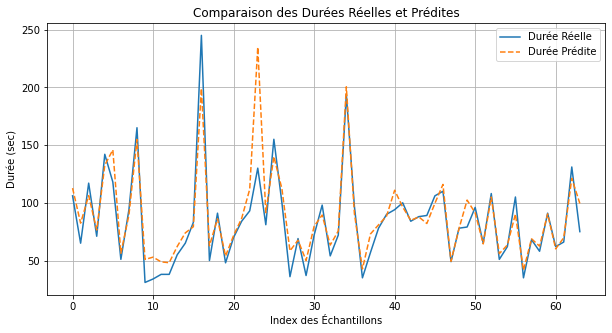

In [0]:
# Importation de Matplotlib pour la visualisation des données
import matplotlib.pyplot as plt

# Conversion du DataFrame Spark en DataFrame Pandas pour faciliter la visualisation
df_pandas = predictions.select("DURATION_IN_SEC", "prediction").toPandas()

# Visualisation des prédictions vs les valeurs réelles
plt.figure(figsize=(10,5))  # Définir la taille de la figure
plt.plot(df_pandas['DURATION_IN_SEC'], label='Durée Réelle')  # Tracer les valeurs réelles de la durée
plt.plot(df_pandas['prediction'], label='Durée Prédite', linestyle='dashed')  # Tracer les prédictions avec un style en pointillé
plt.legend()  # Ajouter une légende pour distinguer les courbes
plt.xlabel('Index des Échantillons')  # Nommer l'axe des x (index des échantillons)
plt.ylabel('Durée (sec)')  # Nommer l'axe des y (durée en secondes)
plt.title('Comparaison des Durées Réelles et Prédites')  # Ajouter un titre au graphique
plt.grid(True)  # Ajouter une grille pour faciliter la lecture du graphique
plt.show()  # Afficher le graphique


In [0]:
# Calculer les statistiques descriptives des prédictions
predictions.describe("prediction").show()

# Calculer le 95e percentile des prédictions
percentile_95 = df_pandas['prediction'].quantile(0.95)
print(f"95e percentile des prédictions : {percentile_95} secondes")


+-------+------------------+
|summary|        prediction|
+-------+------------------+
|  count|                64|
|   mean| 88.64390364583336|
| stddev|37.428192814726856|
|    min|             41.56|
|    max|            234.78|
+-------+------------------+

95e percentile des prédictions : 153.41387499999996 secondes


In [0]:
# Définir un seuil pour les alertes 
threshold = 137

# Ajouter une colonne "alert" si la prédiction dépasse le seuil
df_decision = predictions.withColumn("alert", predictions["prediction"] > threshold)

# Afficher les résultats avec des alertes 'true'
df_decision.filter(df_decision["alert"] == True).select("POINT_1_STREET", "POINT_2_STREET", "prediction", "alert").show()

+-------------------+----------------+----------+-----+
|     POINT_1_STREET|  POINT_2_STREET|prediction|alert|
+-------------------+----------------+----------+-----+
|Djurslandmotorvejen|      Lystrupvej|  145.8425| true|
|           Genvejen|     Møllebakken|    154.75| true|
|           Grenåvej|        Grenåvej|    198.96| true|
|         Landevejen|      Landevejen|    234.78| true|
|        Møllebakken|        Genvejen|  140.0125| true|
|         Randersvej|Vejlby Centervej|   200.425| true|
+-------------------+----------------+----------+-----+



In [0]:
# Filtrer les trajets avec alerte de congestion
df_alerts = df_decision.filter(df_decision["alert"] == True)

# Vérifier le nombre de trajets avec alerte de congestion
nb_alerts = df_alerts.count()
print(f"Nombre de trajets avec alerte de congestion : {nb_alerts}")

# Si aucun trajet congestionné, afficher un message
if nb_alerts == 0:
    print("Aucun trajet congestionné détecté.")
else:
    # Si des trajets sont congestionnés, afficher les détails
    df_alerts.select("POINT_1_STREET", "POINT_2_STREET", "prediction", "alert").show()



Nombre de trajets avec alerte de congestion : 6
+-------------------+----------------+----------+-----+
|     POINT_1_STREET|  POINT_2_STREET|prediction|alert|
+-------------------+----------------+----------+-----+
|Djurslandmotorvejen|      Lystrupvej|  145.8425| true|
|           Genvejen|     Møllebakken|    154.75| true|
|           Grenåvej|        Grenåvej|    198.96| true|
|         Landevejen|      Landevejen|    234.78| true|
|        Møllebakken|        Genvejen|  140.0125| true|
|         Randersvej|Vejlby Centervej|   200.425| true|
+-------------------+----------------+----------+-----+



In [0]:
from geopy.distance import geodesic

def suggest_alternative_routes(df_all_routes, congested_routes, min_distance_between_points=2.5):
    """
    Proposer des routes alternatives aux routes congestionnées.
    :param df_all_routes: DataFrame contenant toutes les routes.
    :param congested_routes: DataFrame des routes congestionnées.
    :param min_distance_between_points: Distance minimale entre les points pour éviter les itinéraires similaires.
    """
    alternatives = []
    seen_routes = set()  # Utiliser un set pour suivre les itinéraires uniques

    # Parcourir les routes disponibles pour proposer des routes alternatives
    for row in df_all_routes.collect():
        point1_lat, point1_lng = row['POINT_1_LAT'], row['POINT_1_LNG']
        point2_lat, point2_lng = row['POINT_2_LAT'], row['POINT_2_LNG']
        point1_street, point2_street = row['POINT_1_STREET'], row['POINT_2_STREET']
        
        # Vérifier si les points sont valides
        if None in (point1_lat, point1_lng, point2_lat, point2_lng):
            continue

        # Vérifier si cette route fait partie des routes congestionnées 
        if any((row['POINT_1_STREET'] == c['POINT_1_STREET'] and row['POINT_2_STREET'] == c['POINT_2_STREET']) 
               for c in congested_routes.collect()):
            continue  # Si cette route est congestionnée, on ne la propose pas

        # Vérifier si le point de départ et d'arrivée sont sur la même rue 
        if point1_street == point2_street:
            continue  # Ignorer cet itinéraire

        # Calculer la distance entre les points de départ et d'arrivée pour vérifier s'ils sont trop proches
        distance_between_points = geodesic((point1_lat, point1_lng), (point2_lat, point2_lng)).km

        # Si la distance entre les deux points est trop faible, ignorer cet itinéraire
        if distance_between_points < min_distance_between_points:
            continue
        
        # Stocker l'itinéraire sous forme d'une chaîne unique pour éviter les répétitions
        route_key = f"{point1_street} to {point2_street}"
        
        # Si cet itinéraire a déjà été ajouté, on l'ignore
        if route_key in seen_routes:
            continue
        
        # Ajouter l'itinéraire dans les routes vues
        seen_routes.add(route_key)
        
        # Proposer des itinéraires alternatifs avec une distance minimale
        alternatives.append({
            "Route alternative": route_key,
            "Distance between points": distance_between_points
        })
    
    # Affichage des résultats
    if alternatives:
        for route in alternatives:
            print(f"\nRoute alternative : {route['Route alternative']}")
            print(f"Distance entre les points de cette route : {route['Distance between points']:.2f} km")
    else:
        print("Aucune route alternative disponible.")

# Appeler la fonction pour proposer des itinéraires alternatifs
congested_routes = df_decision.filter(df_decision["alert"] == True)  # Routes congestionnées identifiées
suggest_alternative_routes(df_final_scaled, congested_routes)



Route alternative : Hovedvejen to Møllebakken
Distance entre les points de cette route : 3.33 km

Route alternative : Møllebakken to Hovedvejen
Distance entre les points de cette route : 3.34 km

Route alternative : Oddervej to Århusvej
Distance entre les points de cette route : 12.84 km

Route alternative : Århusvej to Oddervej
Distance entre les points de cette route : 12.84 km

Route alternative : Nordjyske Motorvej to 15
Distance entre les points de cette route : 2.65 km

Route alternative : Århusvej to Søftenvej
Distance entre les points de cette route : 2.85 km

Route alternative : Søftenvej to Århusvej
Distance entre les points de cette route : 2.85 km

Route alternative : 15 to Nordjyske Motorvej
Distance entre les points de cette route : 2.63 km

Route alternative : 15 to Djurslandmotorvejen
Distance entre les points de cette route : 6.42 km

Route alternative : Djurslandmotorvejen to 15
Distance entre les points de cette route : 6.40 km

Route alternative : Vejlby Centervej 